In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

/home/roz/anaconda3/envs/NN/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Download and load the dataset.
fpath = keras.utils.get_file(
   "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print(f'ytrain shape: {y_train.shape}')
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

ytrain shape: (900, 19, 64, 64, 1)
Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Displaying frames for example 5.


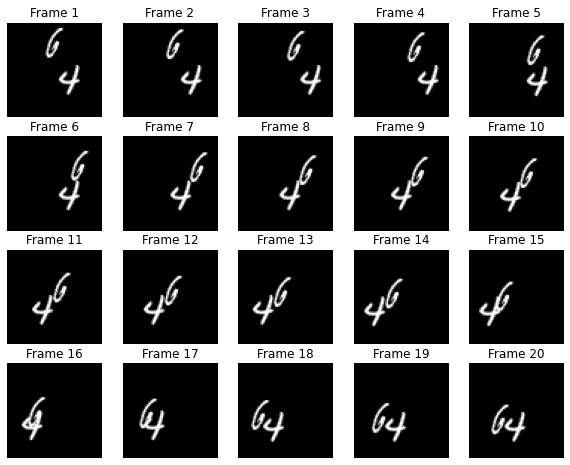

In [4]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [5]:

from keras.activations import hard_sigmoid, relu
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers import ConvLSTM2D
from tensorflow.keras import layers
from keras.layers import Layer
#from keras.layers import BatchNormalization
from numpy import reshape, true_divide

#encoder
#convolutional- lstm layers

inp = layers.Input(shape=(None, *x_train.shape[2:]))



class ReshapeLayer(Layer):
    def call(self,inputs):
        nshape = (5,19) + inputs.shape[1:]
        return tf.reshape(inputs,nshape)

def decon(filter, stride): 
    return Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(stride,stride),padding='same', activation= relu)

def con(filter, stride):
    return Conv2D(filters=filter, kernel_size=(3,3), strides= (stride,stride),padding= 'same')

#input_image = Input(shape=(frames, channels, width, height))

input_ = inp

def depthnet(): 

    cnvlstm1= ConvLSTM2D(32, kernel_size=(7,7), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(input_) #32
    skip1 = tf.reshape (cnvlstm1,(-1,64,64,32))
    #nm1=BatchNormalization(cnvlstm1)
    print(f'first shape: {cnvlstm1.shape}')
    cnvlstm2= ConvLSTM2D(64, kernel_size=(5,5), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm1) #64
    print(f'second shape: {cnvlstm2.shape}')
    cnvlstm3= ConvLSTM2D(64, kernel_size=(5,5), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm2) #64
    print(f'third shape: {cnvlstm3.shape}')
    skip3 = tf.reshape (cnvlstm3,(-1,32,32,64))
    #nm2=BatchNormalization(cnvlstm3)
    cnvlstm4= ConvLSTM2D(128, kernel_size=(3,3), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm3) #128
    print(f'4ht shape: {cnvlstm4.shape}')
    cnvlstm5= ConvLSTM2D(128, kernel_size=(3,3), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm4) #128
    print(f'5th shape: {cnvlstm5.shape}')
    skip5 = tf.reshape (cnvlstm5,(-1,16,16,128))
    #nm3=BatchNormalization(cnvlstm5)
    cnvlstm6= ConvLSTM2D(256, kernel_size=(3,3), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm5) #256
    print(f'6th shape: {cnvlstm6.shape}')
    skip6 = tf.reshape (cnvlstm6,(-1,8,8,256))
    cnvlstm7= ConvLSTM2D(256, kernel_size=(3,3), strides=1, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm6)#256
    print(f'7th shape: {cnvlstm7.shape}')
    #nm4=BatchNormalization(cnvlstm7)
    cnvlstm8= ConvLSTM2D(512, kernel_size=(3,3), strides=2, padding= 'same',  activation= relu,recurrent_activation=hard_sigmoid,return_sequences= True)(cnvlstm7)#512
    print(f'8th shape: {cnvlstm8.shape}')
    cnvlstm8= tf.reshape (cnvlstm8,(-1,4,4,512))
    #cnvlstm8=BatchNormalization(axis=1)(cnvlstm8)
    #decoder 
    dec1=  decon(512,1)(cnvlstm8)
    print(f'dec1 shape: {dec1.shape}')
    print(f'cnvlstm8 shape: {cnvlstm8.shape}')
    conc1= Concatenate()( [dec1 , cnvlstm8])
    conv1= con(512,1)(conc1)
    print(f'conv1 shape: {conv1.shape}')
    #nm6= BatchNormalization(conv1)

    dec2=  decon(256,2)(conv1)
    dec2= decon(256,1)(dec2)
    print(f'dec2 shape: {dec2.shape}')
    conc2= Concatenate()( [dec2 , skip6])
    conv2= con(256,1)(conc2)
    print(f'conv2 shape: {conv2.shape}')
    #nm7= BatchNormalization(conv2)

    dec3=  decon(128,2)(conv2)
    dec3=  decon(128,1)(dec3)
    print(f'dec3 shape: {dec3.shape}')
    conc3= Concatenate()( [dec3 , skip5])
    conv3= con(128, 1)(conc3)
    print(f'conv3: {conv3.shape}')
    #nm6= BatchNormalization(conv3)

    dec4=  decon(64,2)(conv3)
    dec4=  decon(64,1)(dec4)
    print(f'dec4: {dec4.shape}')
    conc4= Concatenate()( [dec4 , skip3])
    print(f'conc4: {conc4.shape}')
    conv4= con(64, 1)(conc4)
    print(f'conv4: {conv4.shape}')
    #nm6= BatchNormalization(conv4)

    dec5=  decon(32,2)(conv4)
    dec5=  decon(32,1)(dec5)
    print(f'dec5: {dec5.shape}')
    conc5= Concatenate()( [dec5 , skip1])
    print(f'conc5: {conc5.shape}')
    conv5= con(32, 1)(conc5)
    print(f'conv5: {conv5.shape}')
    #conv5= BatchNormalization(conv5)
    
    dep = Conv2D(1, (1, 1), activation='sigmoid')(conv5)
    out = ReshapeLayer()(dep)
    #out = Reshape (-1,64,64,1) (dep)
    print(f'dep: {out.shape}')
    net_model = keras.Model(inputs= [input_] , outputs= [out])
    net_model.summary()
    return net_model

In [8]:
from keras import Model
model = depthnet()
model.summary()

# loss function
def custom_loss_function(target, output):
    print(f'output: {output.shape}')
    print(f'target: {target.shape}')
    di = output - target
    #di = tf.math.log(output) - tf.math.log(target)
    n = (64 * 64)
    di2 = tf.math.pow(di, 2)
    fisrt_term = tf.reduce_sum(di2)/n
    second_term = 0.5*tf.math.pow(tf.reduce_sum(di), 2)/ (n**2)
    loss = fisrt_term - second_term
    return loss

# Compile
model.compile(loss=custom_loss_function)

epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs)

2022-10-27 12:45:51.333508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 12:45:51.334763: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


first shape: (None, None, 64, 64, 32)
second shape: (None, None, 32, 32, 64)
third shape: (None, None, 32, 32, 64)
4ht shape: (None, None, 16, 16, 128)
5th shape: (None, None, 16, 16, 128)
6th shape: (None, None, 8, 8, 256)
7th shape: (None, None, 8, 8, 256)
8th shape: (None, None, 4, 4, 512)
dec1 shape: (None, 4, 4, 512)
cnvlstm8 shape: (None, 4, 4, 512)
conv1 shape: (None, 4, 4, 512)
dec2 shape: (None, 8, 8, 256)
conv2 shape: (None, 8, 8, 256)
dec3 shape: (None, 16, 16, 128)
conv3: (None, 16, 16, 128)
dec4: (None, 32, 32, 64)
conc4: (None, 32, 32, 128)
conv4: (None, 32, 32, 64)
dec5: (None, 64, 64, 32)
conc5: (None, 64, 64, 64)
conv5: (None, 64, 64, 32)
dep: (5, 19, 64, 64, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 64, 6  0           []                               


In [ ]:
 def scale_invariant_error(self, y_true, y_pred):
        first_log = K.log(K.clip(y_pred, K.epsilon(), np.inf) + 1.)
        second_log = K.log(K.clip(y_true, K.epsilon(), np.inf) + 1.)
        return K.mean(K.square(first_log - second_log), axis=-1) - self.config['LAMBDA'] * K.square(K.mean(first_log - second_log, axis=-1))
